In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import nltk
import sentencepiece as spm
from nltk.translate.bleu_score import sentence_bleu
from nltk.translate.bleu_score import SmoothingFunction

import re
import os
import random
import math

from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

print(tf.__version__)

2.6.0


# 데이터

## 다운로드

In [2]:
origin_data = pd.read_csv('./data/ChatbotData.csv')

In [3]:
origin_data.head()

,Q,A,label
0,12시 땡!,하루가 또 가네요.,0
1,1지망 학교 떨어졌어,위로해 드립니다.,0
2,3박4일 놀러가고 싶다,여행은 언제나 좋죠.,0
3,3박4일 정도 놀러가고 싶다,여행은 언제나 좋죠.,0
4,PPL 심하네,눈살이 찌푸려지죠.,0


In [4]:
origin_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11823 entries, 0 to 11822
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Q       11823 non-null  object
 1   A       11823 non-null  object
 2   label   11823 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 277.2+ KB


In [5]:
questions = origin_data['Q']
answers = origin_data['A']

## 전처리

In [6]:
def preprocess_sentence(sentence):
    # 소문자로 변환
    sentence = sentence.lower()
    # 영문자, 한글, 숫자, 주요 특수문자만 살리기
    sentence = re.sub(r'[^A-Za-zㄱ-ㅎ가-힣ㅏ-ㅣ0-9?.!,]', '', sentence)
    return sentence

In [7]:
preprocess_sentence("dk109sd\]ㅇ마리단./~?!")

'dk109sdㅇ마리단.?!'

## 토큰화

In [8]:
from konlpy.tag import Mecab
    
tokenizer = Mecab()
def preprocess_tokeinze(sentence, tokenizer):
    # 전처리
    preprocessed = preprocess_sentence(sentence)
    # 토큰화
    return tokenizer.morphs(sentence)

tokenized_que = []
tokenized_ans = []

for question, answer in zip(questions, answers):
    tokenized_que.append(preprocess_tokeinze(question, tokenizer))
    tokenized_ans.append(preprocess_tokeinze(answer, tokenizer))

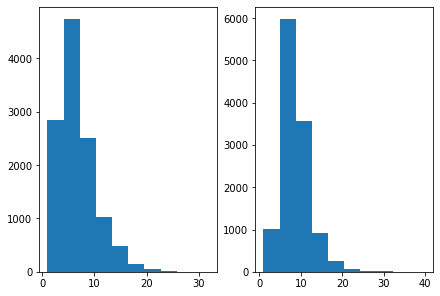

In [9]:
lengths_que = list(map(len, tokenized_que))
lengths_ans = list(map(len, tokenized_ans))
fig, ax = plt.subplots(1, 2, constrained_layout=True)
ax[0].hist(lengths_que)
ax[1].hist(lengths_ans)
plt.show()

In [10]:
# 최대 길이 20으로 설정
MAX_LEN = 20

In [11]:
def find_duplicates(arr):
    df = pd.DataFrame(arr)
    duplicates = df.duplicated()
    duplicate_idx = df.index[duplicates].tolist()
    return duplicate_idx
    
def build_corpus(src, tgt, tokenizer, remove_duplicate=True):
    # 전처리 및 토큰화
    tokenized_src = []
    tokenized_tgt = []

    for src_sentence, tgt_sentence in zip(src, tgt):
        tokenized_src.append(preprocess_tokeinze(src_sentence, tokenizer))
        tokenized_tgt.append(preprocess_tokeinze(tgt_sentence, tokenizer))
        
    # 중복 처리
    if remove_duplicate:
        src_duplicate_idx = find_duplicates(tokenized_src)
        tgt_duplicate_idx = find_duplicates(tokenized_tgt)
        src_duplicate_idx.extend(tgt_duplicate_idx)
        duplicate_idx = set(src_duplicate_idx)
        result_src = [tokenized_src[i] for i in range(len(tokenized_src)) if i not in duplicate_idx]
        result_tgt = [tokenized_tgt[i] for i in range(len(tokenized_tgt)) if i not in duplicate_idx]
        return result_src, result_tgt
    
    return tokenized_src, tokenized_tgt      

중복을 제거하는 것이 성능에 도움되는 지 모르겠음

In [12]:
que_corpus, ans_corpus = build_corpus(questions, answers, tokenizer)

In [13]:
print(len(que_corpus))
print(que_corpus[:5])
print(len(ans_corpus))
print(ans_corpus[:5])

7653
[['12', '시', '땡', '!'], ['1', '지망', '학교', '떨어졌', '어'], ['3', '박', '4', '일', '놀', '러', '가', '고', '싶', '다'], ['PPL', '심하', '네'], ['SD', '카드', '망가졌', '어']]
7653
[['하루', '가', '또', '가', '네요', '.'], ['위로', '해', '드립니다', '.'], ['여행', '은', '언제나', '좋', '죠', '.'], ['눈살', '이', '찌푸려', '지', '죠', '.'], ['다시', '새로', '사', '는', '게', '마음', '편해요', '.']]


## Augmentation
https://github.com/Kyubyong/wordvectors?tab=readme-ov-file

In [14]:
!pip install gensim==3.8.3

In [15]:
import gensim
print(gensim.__version__)

3.8.3


In [16]:
from gensim.models import Word2Vec

# 저장된 Word2Vec 모델 파일 불러오기
model = Word2Vec.load('./data/ko.bin')

In [17]:
def lexical_sub(tokens, wv):
    selected_tok = random.choice(tokens)

    result = ""
    for tok in tokens:
        if tok is selected_tok and tok in wv:
            result += wv.most_similar(tok)[0][0] + " "

        else:
            result += tok + " "
    
    return result

In [18]:
wv = model.wv
new_que_corpus = []
new_ans_corpus = []

new_que_corpus.extend(que_corpus)
new_ans_corpus.extend(ans_corpus)

use_aug=False
if use_aug:
    for que, ans in tqdm(zip(que_corpus, ans_corpus), total=len(que_corpus)):
        new_que_corpus.append(lexical_sub(que, wv))
        new_ans_corpus.append(ans)
        new_que_corpus.append(que)
        new_ans_corpus.append(lexical_sub(ans, wv))

print(len(new_que_corpus))
print(len(new_ans_corpus))

7653
7653


In [19]:
print(new_ans_corpus[0])
if use_aug:
    # 증강된 데이터 확인
    print(new_ans_corpus[len(ans_corpus)+1])

['하루', '가', '또', '가', '네요', '.']


## 사전 구성

In [20]:
# 문자열을 리스트로 변환
def str2list(tokens):
    if not isinstance(tokens, list):
        return tokens.split() 
    else:
        return tokens
    
# 시작토큰, 종료토큰 추가
def add_s_e_token(tokens):
    # 리스트를 문자열로 변환
    if isinstance(tokens, list):
        tokens = ' '.join(tokens)
    sentence = '<start> ' + tokens + ' <end>'
    # 문자열을 리스트로 변환
    return sentence.split()

final_que_corpus = list(map(str2list, new_ans_corpus))
final_ans_corpus = list(map(add_s_e_token, new_ans_corpus))

In [21]:
print(final_ans_corpus[0])

['<start>', '하루', '가', '또', '가', '네요', '.', '<end>']


In [22]:
from collections import Counter

words = np.concatenate(final_que_corpus).tolist() + np.concatenate(final_ans_corpus).tolist()

counter = Counter(words)
print(len(counter.most_common()))

3887


단어 개수가 많지 않으므로 그대로 사용

In [23]:
VOCAB_SIZE = len(counter.most_common())+2

In [24]:
vocab = [key for key, _ in counter.most_common()]
word2idx = {word:index+2 for index, word in enumerate(vocab)}    # 인덱스 0, 1은 패딩과 unk 토큰을 위해 비워둠
word2idx['<pad>'] = 0
word2idx['<unk>'] = 1

## 벡터화

In [25]:
enc_ndarray = [[word2idx.get(word, 1) for word in sentence] for sentence in final_que_corpus]
dec_ndarray = [[word2idx.get(word, 1) for word in sentence] for sentence in final_ans_corpus]

### 패딩 적용

In [26]:
enc = tf.keras.preprocessing.sequence.pad_sequences(enc_ndarray, maxlen=MAX_LEN, padding='post')
dec = tf.keras.preprocessing.sequence.pad_sequences(dec_ndarray, maxlen=MAX_LEN, padding='post')

## 데이터셋 분할

In [27]:
from sklearn.model_selection import train_test_split

enc_train, enc_val, dec_train, dec_val = train_test_split(enc, dec, test_size=0.1, random_state=123)

print(enc_train.shape)
print(dec_train.shape)
print(enc_val.shape)
print(dec_val.shape)

(6887, 20)
(6887, 20)
(766, 20)
(766, 20)


# 모델링
트랜스포머 - Encoder와 Decoder 각각의 Embedding과 출력층의 Linear, 총 3개의 레이어가 Weight를 공유

>**모델 선정 이유**: 트랜스포머는 자연어처리 분야에서 좋은 성능을 내고 있기에 챗봇을 만들 때 사용하기 좋다. 다만, 사전학습된 트랜스포머 모델을 쓰면 더 좋은 성능을 낼 것으로 예상한다

## positional encoding

In [28]:
def positional_encoding(pos, d_model):
    def cal_angle(position, i):
        return position / np.power(10000, (2*(i//2)) / np.float32(d_model))

    def get_posi_angle_vec(position):
        return [cal_angle(position, i) for i in range(d_model)]

    sinusoid_table = np.array([get_posi_angle_vec(pos_i) for pos_i in range(pos)])

    sinusoid_table[:, 0::2] = np.sin(sinusoid_table[:, 0::2])
    sinusoid_table[:, 1::2] = np.cos(sinusoid_table[:, 1::2])

    return sinusoid_table

## Masking

In [29]:
def generate_padding_mask(seq):
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
    return seq[:, tf.newaxis, tf.newaxis, :]

def generate_lookahead_mask(size):
    mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
    return mask

def generate_masks(src, tgt):
    enc_mask = generate_padding_mask(src)
    dec_enc_mask = generate_padding_mask(src)

    dec_lookahead_mask = generate_lookahead_mask(tgt.shape[1])
    dec_tgt_padding_mask = generate_padding_mask(tgt)
    dec_mask = tf.maximum(dec_tgt_padding_mask, dec_lookahead_mask)

    return enc_mask, dec_enc_mask, dec_mask

## Multi-Head Attention

In [30]:
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model
        
        self.depth = d_model // self.num_heads
        
        self.W_q = tf.keras.layers.Dense(d_model)
        self.W_k = tf.keras.layers.Dense(d_model)
        self.W_v = tf.keras.layers.Dense(d_model)
        
        self.linear = tf.keras.layers.Dense(d_model)

    def scaled_dot_product_attention(self, Q, K, V, mask):
        d_k = tf.cast(K.shape[-1], tf.float32)
        QK = tf.matmul(Q, K, transpose_b=True)

        scaled_qk = QK / tf.math.sqrt(d_k)

        if mask is not None: scaled_qk += (mask * -1e9)  

        attentions = tf.nn.softmax(scaled_qk, axis=-1)
        out = tf.matmul(attentions, V)

        return out, attentions
        
        
    def split_heads(self, x):
        bsz = x.shape[0]
        split_x = tf.reshape(x, (bsz, -1, self.num_heads, self.depth))
        split_x = tf.transpose(split_x, perm=[0, 2, 1, 3])

        return split_x

    def combine_heads(self, x):
        bsz = x.shape[0]
        combined_x = tf.transpose(x, perm=[0, 2, 1, 3])
        combined_x = tf.reshape(combined_x, (bsz, -1, self.d_model))

        return combined_x

    
    def call(self, Q, K, V, mask):
        WQ = self.W_q(Q)
        WK = self.W_k(K)
        WV = self.W_v(V)
        
        WQ_splits = self.split_heads(WQ)
        WK_splits = self.split_heads(WK)
        WV_splits = self.split_heads(WV)
        
        out, attention_weights = self.scaled_dot_product_attention(
            WQ_splits, WK_splits, WV_splits, mask)
                        
        out = self.combine_heads(out)
        out = self.linear(out)
            
        return out, attention_weights

## Position-wise Feed Forward Network

In [31]:
class PoswiseFeedForwardNet(tf.keras.layers.Layer):
    def __init__(self, d_model, d_ff):
        super(PoswiseFeedForwardNet, self).__init__()
        self.d_model = d_model
        self.d_ff = d_ff

        self.fc1 = tf.keras.layers.Dense(d_ff, activation='relu')
        self.fc2 = tf.keras.layers.Dense(d_model)

    def call(self, x):
        out = self.fc1(x)
        out = self.fc2(out)
            
        return out

## Encoder

In [32]:
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, n_heads, d_ff, dropout):
        super(EncoderLayer, self).__init__()

        self.enc_self_attn = MultiHeadAttention(d_model, n_heads)
        self.ffn = PoswiseFeedForwardNet(d_model, d_ff)

        self.norm_1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.do = tf.keras.layers.Dropout(dropout)
        
    def call(self, x, mask):
        '''
        Multi-Head Attention
        '''
        residual = x
        out = self.norm_1(x)
        out, enc_attn = self.enc_self_attn(out, out, out, mask)
        out = self.do(out)
        out += residual
        
        '''
        Position-Wise Feed Forward Network
        '''
        residual = out
        out = self.norm_2(out)
        out = self.ffn(out)
        out = self.do(out)
        out += residual
        
        return out, enc_attn

In [33]:
class Encoder(tf.keras.Model):
    def __init__(self,
                    n_layers,
                    d_model,
                    n_heads,
                    d_ff,
                    dropout):
        super(Encoder, self).__init__()
        self.n_layers = n_layers
        self.enc_layers = [EncoderLayer(d_model, n_heads, d_ff, dropout) 
                        for _ in range(n_layers)]
    
        self.do = tf.keras.layers.Dropout(dropout)
        
    def call(self, x, mask):
        out = x
    
        enc_attns = list()
        for i in range(self.n_layers):
            out, enc_attn = self.enc_layers[i](out, mask)
            enc_attns.append(enc_attn)
        
        return out, enc_attns

## Decoder

In [34]:
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, d_ff, dropout):
        super(DecoderLayer, self).__init__()

        self.dec_self_attn = MultiHeadAttention(d_model, num_heads)
        self.enc_dec_attn = MultiHeadAttention(d_model, num_heads)

        self.ffn = PoswiseFeedForwardNet(d_model, d_ff)

        self.norm_1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.do = tf.keras.layers.Dropout(dropout)
    
    def call(self, x, enc_out, dec_enc_mask, padding_mask):
        '''
        Masked Multi-Head Attention
        '''
        residual = x
        out = self.norm_1(x)
        out, dec_attn = self.dec_self_attn(out, out, out, padding_mask)
        out = self.do(out)
        out += residual

        '''
        Multi-Head Attention
        '''
        residual = out
        out = self.norm_2(out)
        out, dec_enc_attn = self.enc_dec_attn(Q=out, K=enc_out, V=enc_out, mask=dec_enc_mask)
        out = self.do(out)
        out += residual
        
        '''
        Position-Wise Feed Forward Network
        '''
        residual = out
        out = self.norm_3(out)
        out = self.ffn(out)
        out = self.do(out)
        out += residual

        return out, dec_attn, dec_enc_attn

In [35]:
class Decoder(tf.keras.Model):
    def __init__(self,
                    n_layers,
                    d_model,
                    n_heads,
                    d_ff,
                    dropout):
        super(Decoder, self).__init__()
        self.n_layers = n_layers
        self.dec_layers = [DecoderLayer(d_model, n_heads, d_ff, dropout) 
                            for _ in range(n_layers)]
                            
    def call(self, x, enc_out, dec_enc_mask, padding_mask):
        out = x
    
        dec_attns = list()
        dec_enc_attns = list()
        for i in range(self.n_layers):
            out, dec_attn, dec_enc_attn = \
            self.dec_layers[i](out, enc_out, dec_enc_mask, padding_mask)

            dec_attns.append(dec_attn)
            dec_enc_attns.append(dec_enc_attn)

        return out, dec_attns, dec_enc_attns

## 전체 모델

In [36]:
class Transformer(tf.keras.Model):
    def __init__(self,
                    n_layers,
                    d_model,
                    n_heads,
                    d_ff,
                    src_vocab_size,
                    tgt_vocab_size,
                    pos_len,
                    dropout=0.2,
                    shared_fc=True,
                    shared_emb=False):
        super(Transformer, self).__init__()
        
        self.d_model = tf.cast(d_model, tf.float32)

        if shared_emb:
            self.enc_emb = self.dec_emb = \
            tf.keras.layers.Embedding(src_vocab_size, d_model)
        else:
            self.enc_emb = tf.keras.layers.Embedding(src_vocab_size, d_model)
            self.dec_emb = tf.keras.layers.Embedding(tgt_vocab_size, d_model)

        self.pos_encoding = positional_encoding(pos_len, d_model)
        self.do = tf.keras.layers.Dropout(dropout)

        self.encoder = Encoder(n_layers, d_model, n_heads, d_ff, dropout)
        self.decoder = Decoder(n_layers, d_model, n_heads, d_ff, dropout)

        self.fc = tf.keras.layers.Dense(tgt_vocab_size)

        self.shared_fc = shared_fc

        if shared_fc:
            self.fc.set_weights(tf.transpose(self.dec_emb.weights))

    def embedding(self, emb, x):
        seq_len = x.shape[1]

        out = emb(x)

        if self.shared_fc: out *= tf.math.sqrt(self.d_model)

        out += self.pos_encoding[np.newaxis, ...][:, :seq_len, :]
        out = self.do(out)

        return out

        
    def call(self, enc_in, dec_in, enc_mask, dec_enc_mask, dec_mask):
        enc_in = self.embedding(self.enc_emb, enc_in)
        dec_in = self.embedding(self.dec_emb, dec_in)

        enc_out, enc_attns = self.encoder(enc_in, enc_mask)
        
        dec_out, dec_attns, dec_enc_attns = \
        self.decoder(dec_in, enc_out, dec_enc_mask, dec_mask)
        
        logits = self.fc(dec_out)
        
        return logits, enc_attns, dec_attns, dec_enc_attns

# 학습

In [37]:
!pip install wandb==0.16.0

In [38]:
import wandb

sweep_config = {
    'method': 'random',
    'metric': {
        'name': 'loss',
        'goal': 'minimize'
    },
    'parameters': {
        'epoch' : {
            'distribution' : 'int_uniform',
            'min' : 2,
            'max' : 5
        },
        'embedding_dim': {
            'values': [64, 128, 256]
        },
        'units': {
            'values': [256, 512, 1024, 2048]
        },
        'dropout_rate': {
            'values': [0, 0.1, 0.3]
        },
        'n_layers': {
            'values': [1, 2]
        },
        'd_model': {
            'values': [128, 256, 512]
        },
        'n_heads': {
            'values': [2, 4, 8]
        }
    }
}

```
n_layers = 2
d_model = 512
n_heads = 8
d_ff = 2048
dropout=0.3
shared_fc=True
shared_emb=True
EPOCHS = 3
```
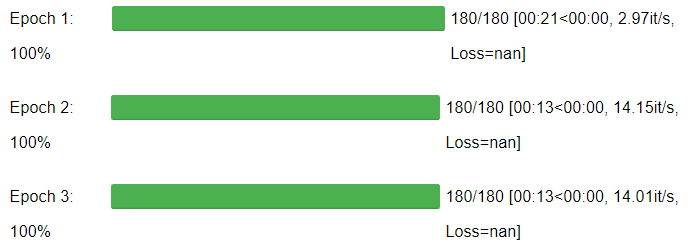

```
BATCH_SIZE = 64
n_layers = 2
d_model = 256
n_heads = 4
d_ff = 1024
dropout=0.3
shared_fc=True
shared_emb=True
EPOCHS = 3
```
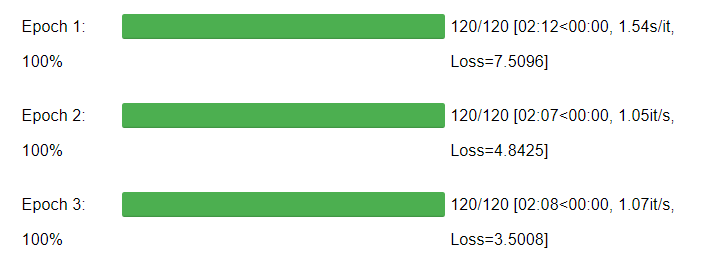

In [39]:
# 데이터셋 구성
BATCH_SIZE = 64
train_dataset = tf.data.Dataset.from_tensor_slices((enc_train, dec_train)).batch(batch_size=BATCH_SIZE)
train_dataset = train_dataset.shuffle(buffer_size=3000, seed=123)

valid_dataset = tf.data.Dataset.from_tensor_slices((enc_val, dec_val)).batch(batch_size=BATCH_SIZE)
valid_dataset = train_dataset.shuffle(buffer_size=1000, seed=123)

## 학습률 스케쥴러

In [40]:
class LearningRateScheduler(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(LearningRateScheduler, self).__init__()
        
        self.d_model = d_model
        self.warmup_steps = warmup_steps
    
    def __call__(self, step):
        arg1 = step ** -0.5
        arg2 = step * (self.warmup_steps ** -1.5)
        
        return (self.d_model ** -0.5) * tf.math.minimum(arg1, arg2)

## 손실함수

In [41]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_sum(loss_)/tf.reduce_sum(mask)

>**loss 선정 이유**: SparseCategoricalCrossentropy() 함수를 사용해 단어장의 단어 중 선택하는 다중 클래스 분류의 loss를 활용함. 또한 loss_function을 따로 정의하여 패딩에 대한 처리를 해 줌

## 훈련

In [56]:
def valid_step(src, tgt, model):
    tgt_in = tgt[:, :-1]
    gold = tgt[:, 1:]

    enc_mask, dec_enc_mask, dec_mask = generate_masks(src, tgt_in)

    predictions, enc_attns, dec_attns, dec_enc_attns = model(
        src, tgt_in, enc_mask, dec_enc_mask, dec_mask
    )

    # 검증 손실 계산
    loss = loss_function(gold, predictions)

    return loss

In [57]:
def train_step(src, tgt, model, optimizer):
    tgt_in = tgt[:, :-1]  # Decoder의 input
    gold = tgt[:, 1:]     # Decoder의 output과 비교하기 위해 right shift를 통해 생성한 최종 타겟

    enc_mask, dec_enc_mask, dec_mask = generate_masks(src, tgt_in)

    with tf.GradientTape() as tape:
        predictions, enc_attns, dec_attns, dec_enc_attns = \
        model(src, tgt_in, enc_mask, dec_enc_mask, dec_mask)
        loss = loss_function(gold, predictions)

    gradients = tape.gradient(loss, model.trainable_variables)    
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    return loss, enc_attns, dec_attns, dec_enc_attns

In [62]:
def wandb_train():
    wandb.init()
    
    config = wandb.config

    shared_fc=True
    shared_emb=True
    
    # 모델 정의
    transformer = Transformer(
        config.n_layers, config.d_model, config.n_heads, config.units, 
        VOCAB_SIZE, VOCAB_SIZE, MAX_LEN, config.dropout_rate, shared_fc, shared_emb)
    
    # optimizer 정의
    learning_rate = LearningRateScheduler(config.d_model)

    optimizer = tf.keras.optimizers.Adam(learning_rate,
                                        beta_1=0.9,
                                        beta_2=0.98, 
                                        epsilon=1e-9)
    
    # early stopping을 위함 
    best_val_loss = np.inf    
    
    EPOCHS = 5
    for epoch in range(EPOCHS):
        # train loss 계산
        total_loss = 0

        dataset_count = tf.data.experimental.cardinality(train_dataset).numpy()
        tqdm_bar = tqdm(train_dataset, total=dataset_count)

        for i, (enc_train, dec_train) in enumerate(tqdm_bar):
            batch_loss, enc_attns, dec_attns, dec_enc_attns = \
                        train_step(enc_train, dec_train, transformer, optimizer)
            total_loss += batch_loss
            wandb.log({'batch_loss': batch_loss.numpy()})
            tqdm_bar.set_description_str('Epoch %2d' % (epoch + 1))
            tqdm_bar.set_postfix(Loss=f'{total_loss / (i + 1):.4f}') 

        train_loss = total_loss / (i + 1)
        wandb.log({'epoch': epoch + 1, 'train_loss': train_loss.numpy()})

        # validation loss 계산
        val_total_loss = 0
        
        val_dataset_count = tf.data.experimental.cardinality(valid_dataset).numpy()
        val_tqdm_bar = tqdm(valid_dataset, total=val_dataset_count)
        
        for i, (enc_val, dec_val) in enumerate(val_tqdm_bar):
            val_batch_loss = valid_step(enc_val, dec_val, transformer)

            val_total_loss += val_batch_loss
            wandb.log({'val_batch_loss': val_batch_loss.numpy()})
            tqdm_bar.set_postfix({'Valid Loss': val_total_loss / (i + 1)})

        val_loss = val_total_loss / (i + 1)
        wandb.log({'val_loss': val_loss.numpy()})

        # Early Stopping
        # 현재 val_loss가 이전 val_loss 보다 좋을 때만 학습 계속 진행
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            # 매 epoch마다 모델 저장
            model_save_path = os.path.join(wandb.run.dir, f'transformer_{epoch+1}')
            transformer.save(model_save_path, save_format='tf')

            # 저장한 모델을 wandb에 저장
            wandb.save(model_save_path)
        else:
            print(f"Early stopping at epoch {epoch + 1} due to validation loss increase.")
            break

    # run 끝내기
    wandb.finish()

In [63]:
sweep_id = wandb.sweep(sweep_config,
                       entity = '4-rldur0',
                       project = 'transformer_chatbot')

wandb.agent(sweep_id, function=wandb_train, count=1)

Create sweep with ID: itkw97un
Sweep URL: https://wandb.ai/4-rldur0/transformer_chatbot/sweeps/itkw97un


wandb: Agent Starting Run: m5jruwxe with config:
wandb: 	d_model: 128
wandb: 	dropout_rate: 0
wandb: 	embedding_dim: 256
wandb: 	epoch: 5
wandb: 	n_heads: 8
wandb: 	n_layers: 1
wandb: 	units: 256


  0%|          | 0/108 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

batch_loss,██████████▇▇▇▇▇▇▇▇▇▆▆▆▆▆▆▅▅▅▅▄▄▄▄▄▃▃▃▂▂▁
epoch,▁
train_loss,▁
val_batch_loss,▆▆▃▂▆▄▆▅▄▃▅▄█▄▄▆▄▄▁▄▄▄▅▄▃▂▁▁▅▅▆▅▇▄▆▅▄▂▄▄
val_loss,▁
batch_loss,7.00164
epoch,1
train_loss,7.96013
val_batch_loss,6.97848
val_loss,6.98208


Run m5jruwxe errored: TypeError('in user code:\n\n    /opt/conda/lib/python3.9/site-packages/keras/saving/saving_utils.py:125 _wrapped_model  *\n        outputs = model(*args, **kwargs)\n    /tmp/ipykernel_708/316502540.py:54 call  *\n        enc_out, enc_attns = self.encoder(enc_in, enc_mask)\n    /tmp/ipykernel_708/3884925815.py:20 call  *\n        out, enc_attn = self.enc_layers[i](out, mask)\n    /tmp/ipykernel_708/2762276407.py:19 call  *\n        out, enc_attn = self.enc_self_attn(out, out, out, mask)\n    /tmp/ipykernel_708/485309987.py:49 call  *\n        WQ_splits = self.split_heads(WQ)\n    /tmp/ipykernel_708/485309987.py:31 split_heads  *\n        split_x = tf.reshape(x, (bsz, -1, self.num_heads, self.depth))\n    /opt/conda/lib/python3.9/site-packages/tensorflow/python/util/dispatch.py:206 wrapper  **\n        return target(*args, **kwargs)\n    /opt/conda/lib/python3.9/site-packages/tensorflow/python/ops/array_ops.py:196 reshape\n        result = gen_array_ops.reshape(tens

마지막 batch에서만 loss가 nan
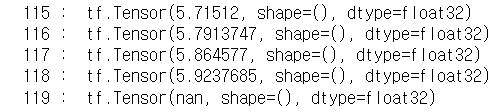  

<예상 원인과 시도>
- input에 nan 있을 수 있음 -> 없음
- batch 크기 1로(batch 크기대로 자를 때 마지막 남는 데이터는 앞의 데이터와 shape이 다름) -> 해결 x
- augmentation 없애기(중복값이 너무 많으면 loss가 NaN이 될 수 있음) -> 해결 x
- 특정 배치에서만 일어나기 때문에 shuffle 사용해서 결과 확인 -> 마지막 batch가 아닌 곳에서 loss nan(seed=123일 때 92번째 batch, 124일 때 47번째 batch). 두 batch 다 shuffle하지 않았다면 마지막 batch였을 batch -> 해당 batch에 무엇인가 문제가 있음
- tf.data.Dataset.from_tensor_slices 사용하지 않기 -> 해결 x
- **하루 뒤 다시 실행해보니 해결됨**(원인 알 수 없음)

# 평가

>**metric 선정 이유**: BLEU score는 번역 task에서 가장 널리 사용되고 있고, 다양한 측면을 고려할 수 있기 때문에 적합하다

In [46]:
def translate(tokens, model, word2idx, idx2word):
    padded_tokens = tf.keras.preprocessing.sequence.pad_sequences([tokens],
                                                           maxlen=MAX_LEN,
                                                           padding='post')
    ids = []
    output = tf.expand_dims([word2idx['<start>']], 0)   
    for i in range(MAX_LEN):
        enc_padding_mask, combined_mask, dec_padding_mask = \
        generate_masks(padded_tokens, output)

        predictions, _, _, _ = model(padded_tokens, 
                                      output,
                                      enc_padding_mask,
                                      combined_mask,
                                      dec_padding_mask)

        predicted_id = \
        tf.argmax(tf.math.softmax(predictions, axis=-1)[0, -1]).numpy().item()
        if word2idx['<end>'] == predicted_id:
            result = [idx2word.get(idx, '<unk>') for idx in ids]
            return ' '.join(result)

        ids.append(predicted_id)
        output = tf.concat([output, tf.expand_dims([predicted_id], 0)], axis=-1)
    result = [idx2word.get(idx, '<unk>') for idx in ids]
    return result

In [47]:
def eval_bleu_single(model, src_sentence, tgt_sentence, tokenizer, word2idx, verbose=True):
    idx2word =  dict((k, v) for v, k in word2idx.items()) 
    src_tokens = preprocess_tokeinze(src_sentence, tokenizer)
    src_vector = [word2idx.get(word, 1) for word in src_tokens]
    tgt_tokens = tgt_sentence.split()
    if (len(src_vector) > MAX_LEN): return None
    if (len(tgt_tokens) > MAX_LEN): return None

    reference = tgt_tokens
    candidate = translate(src_vector, model, word2idx, idx2word)

    score = sentence_bleu([reference], candidate,
                          smoothing_function=SmoothingFunction().method1)

    if verbose:
        print("Source Sentence: ", src_sentence)
        print("Model Prediction: ", candidate)
        print("Real: ", reference)
        print("Score: %lf\n" % score)
        
    return score

In [ ]:
def calculate_bleu(model, src_sentences, tgt_sentence, tokenizer, word2idx, verbose=True):
    total_score = 0.0
    sample_size = len(src_sentences)
    
    for idx in tqdm(range(sample_size)):
        score = eval_bleu_single(model, src_sentences[idx], tgt_sentence[idx], tokenizer, word2idx, verbose)
        if not score: continue
        
        total_score += score
    
    print("Num of Sample:", sample_size)
    print("Total Score:", total_score / sample_size)

In [ ]:
calculate_bleu(transformer, sample_src, sample_tgt, tokenizer, word2idx, verbose=True)